#3.1: Spectrogram Model
# Data Science - Capstone Project Submission

* Student Name: **James Toop**
* Student Pace: **Self Paced**
* Scheduled project review date/time: **29th October 2021 @ 21:30 BST**
* Instructor name: **Jeff Herman / James Irving**
* Blog URL: **https://toopster.github.io/**

---

## Table of Contents
1. [Business Case, Project Purpose and Approach](1_business_case.ipynb#business-case)
    1. [The importance of communication for people with severe learning disabilities](1_business_case.ipynb.ipynb#communication-and-learning-disabilities)
    2. [Types of communication](1_business_case.ipynb.ipynb#types-of-communication)
    3. [Communication techniques for people with learning disabilities](1_business_case.ipynb.ipynb#communication-techniques)
    4. [Project purpose & approach](1_business_case.ipynb.ipynb#project-purpose)
2. [Exploratory Data Analysis](2_eda.ipynb#eda)
    1. [The Datasets](2_eda.ipynb#the-datasets)
    2. [Discovery](2_eda.ipynb#data-discovery)
    3. [Preprocessing](2_eda.ipynb#data-preprocessing)
3. [Deep Learning Neural Networks](#deep-learning-neural-networks)
    1. [Initial Model Using Spectrograms](#model-1)
    2. [Advanced Model using MFCC's](#model-2)
4. [Final Model Performance Evaluation](#final-model-performance-evaluation)

---
<a name="deep-learning-neural-networks"></a>
# 3. Deep Learning Neural Networks

In [1]:
# Import relevant libraries and modules for creating neural networks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wave
import soundfile as sf
import librosa, librosa.display
import IPython.display as ipd
import os
import json

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import pathlib
from pathlib import Path

<a name="model-1"></a>
### 3A. Initial Model using Spectrograms

In [41]:
# Set seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
# Check version of Tensorflow as needs v2.0 and above
tf.__version__

'2.6.0'

In [42]:
# Set the directory path for the Speech Commands dataset
sc_data_dir = pathlib.Path('data/speech_commands_v0.02')

In [43]:
# List the dataset keywords / labels
keywords = np.array(tf.io.gfile.listdir(str(sc_data_dir)))
keywords = keywords[(keywords != 'README.md') & 
                    (keywords != '.DS_Store') & 
                    (keywords != 'LICENSE') & 
                    (keywords != 'validation_list.txt') &
                    (keywords != 'testing_list.txt') &
                    (keywords != '_background_noise_')]
print('Keywords:', keywords)

Keywords: ['right' 'eight' 'cat' 'tree' 'backward' 'learn' 'bed' 'happy' 'go' 'dog'
 'no' 'wow' 'follow' 'nine' 'left' 'stop' 'three' 'sheila' 'one' 'bird'
 'zero' 'seven' 'up' 'visual' 'marvin' 'two' 'house' 'down' 'six' 'yes'
 'on' 'five' 'forward' 'off' 'four']


In [5]:
# Extract the audio files into a list, filter out the background noise folder and shuffle it
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = [x for x in filenames if x != str(data_dir) + '/_background_noise_/']

filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total audio samples:', num_samples)
print('Number of audio samples per label:', len(tf.io.gfile.listdir(str(data_dir/keywords[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 105829
Number of examples per label: 3778
Example file tensor: tf.Tensor(b'data/speech_commands_v0.02/nine/e3e0f145_nohash_4.wav', shape=(), dtype=string)


In [34]:
print(round(num_samples * 0.1))

10583


In [35]:
# Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.
train_files = filenames[:round(num_samples * 0.8)]
val_files = filenames[round(num_samples * 0.8): round(num_samples * 0.8) + round(num_samples * 0.1)]
test_files = filenames[-round(num_samples * 0.1):]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 84663
Validation set size 10583
Test set size 10583


#### Reading audio files and their labels

* Read audio sample as a binary file and convert into a numerical tensor.
* [`tf.audio.decode_wav`](https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav), returns the WAV-encoded audio as a Tensor and the sample rate.
* A WAV file contains time series data with a set number of samples per second. 
* Each sample represents the amplitude of the audio signal at that specific time. In a 16-bit system the values range from -32768 to 32767. 
* The sample rate for this dataset is 16kHz.
* Note that `tf.audio.decode_wav` will normalize the values to the range [-1.0, 1.0].

In [7]:
# Load the audio sample
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

In [8]:
# Get the label for each WAV file from its parent directory
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

In [9]:
# Function to output a tuple containing the audio and labels
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(tf.autograph.experimental.do_not_convert(get_waveform_and_label), 
                           num_parallel_calls=AUTOTUNE)

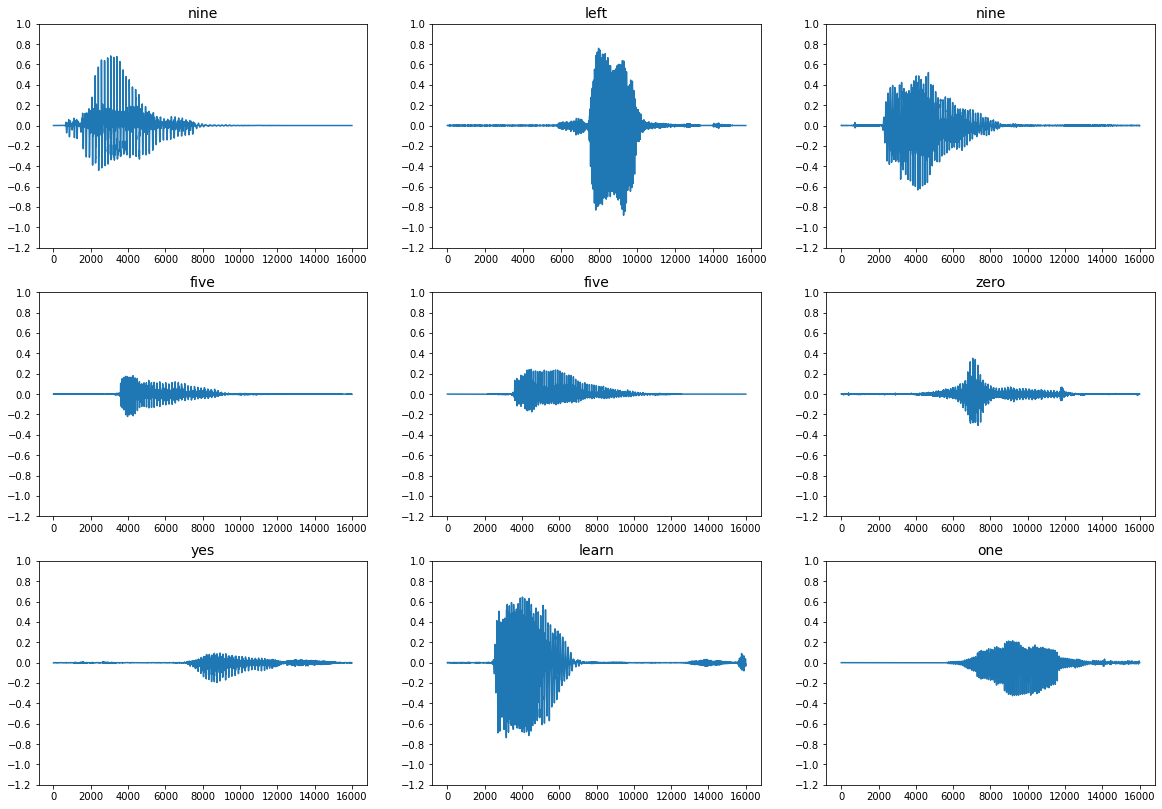

In [40]:
# Examine waveforms and corresponding labels
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 14))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label, fontsize=14)

plt.show();

In [12]:
def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    
    # Concatenate audio with padding so that all audio clips will be of the same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    return spectrogram

#### Convert waveform to spectrogram

* Convert the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image. This can be done by applying the short-time Fourier transform (STFT) to convert the audio into the time-frequency domain.

* A Fourier transform ([`tf.signal.fft`](https://www.tensorflow.org/api_docs/python/tf/signal/fft)) converts a signal to its component frequencies, but loses all time information. The STFT ([`tf.signal.stft`](https://www.tensorflow.org/api_docs/python/tf/signal/stft)) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

* STFT produces an array of complex numbers representing magnitude and phase. However, you'll only need the magnitude for this tutorial, which can be derived by applying `tf.abs` on the output of `tf.signal.stft`. 

* Choose `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on STFT parameters choice, you can refer to [this video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing. 

* You also want the waveforms to have the same length, so that when you convert it to a spectrogram image, the results will have similar dimensions. This can be done by simply zero padding the audio clips that are shorter than one second.

Next, you will explore the data. Compare the waveform, the spectrogram and the actual audio of one example from the dataset.

In [13]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: nine
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


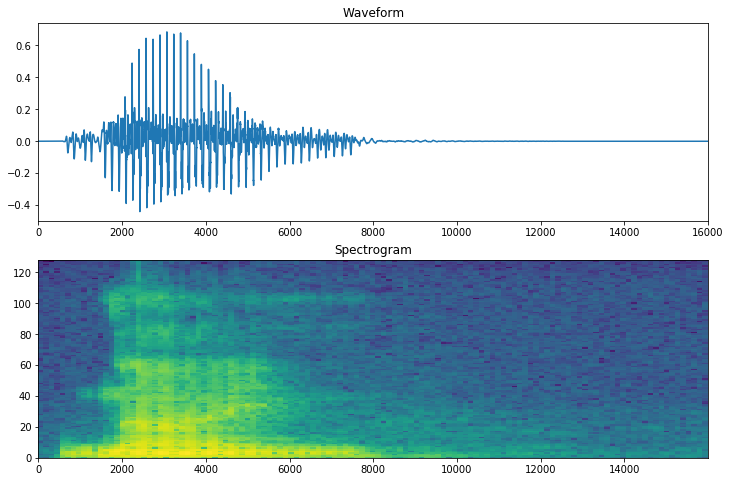

In [14]:
def plot_spectrogram(spectrogram, ax):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns). An epsilon is added to avoid log of zero.
    log_spec = np.log(spectrogram.T+np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show();

In [15]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == keywords)
    return spectrogram, label_id

In [16]:
spectrogram_ds = waveform_ds.map(tf.autograph.experimental.do_not_convert(get_spectrogram_and_label_id), 
                                 num_parallel_calls=AUTOTUNE)

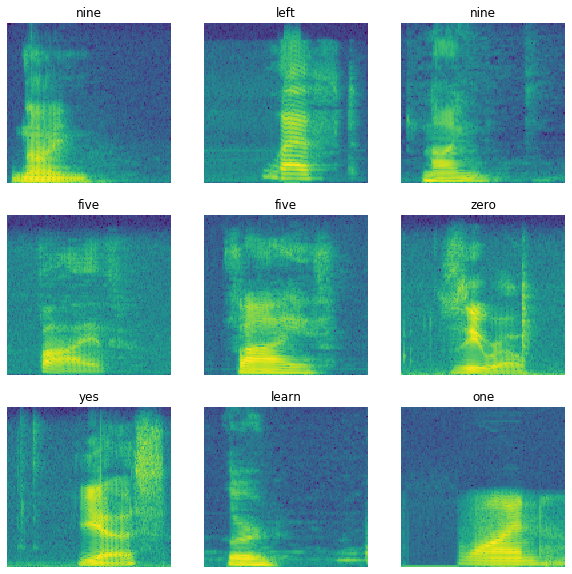

In [17]:
# View spectrograms of random audio samples
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(keywords[label_id.numpy()])
    ax.axis('off')
    
plt.show();

#### Build and train the model

Now you can build and train your model. But before you do that, you'll need to repeat the training set preprocessing on the validation and test sets.

In [18]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(tf.autograph.experimental.do_not_convert(get_waveform_and_label), num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
    
    return output_ds

In [19]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [20]:
# Batch the training and validation sets for model training
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [21]:
# Reduce read latency while training the model
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [22]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(keywords)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(tf.autograph.experimental.do_not_convert(lambda x, _: x)))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary();

Input shape: (124, 129, 1)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
________________________________________________

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [24]:
EPOCHS = 20
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1323/1323 [==============================] - ETA: 0s - loss: 2.0420 - accuracy: 0.4174WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f95d2b84680> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1323/1323 [==============================] - 257s 194ms/step - loss: 2.0420 - accuracy: 0.4174 - val_loss: 1.0619 - val_accuracy: 0.7058
Epoch

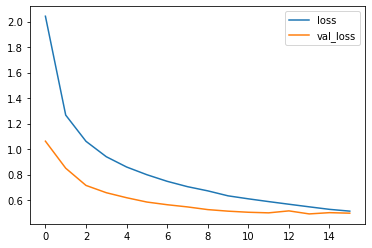

In [25]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [26]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [27]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Test set accuracy: 85%


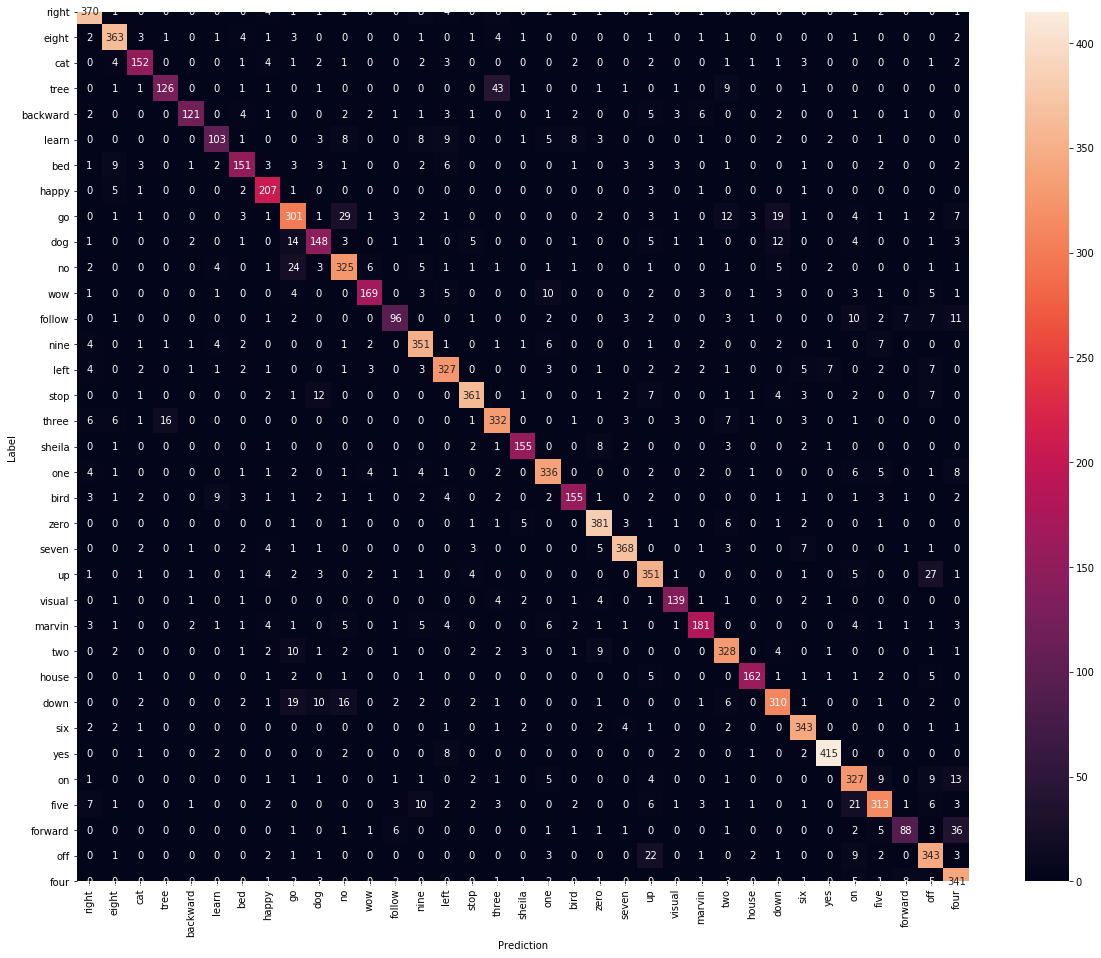

In [28]:
# Plot a confusion matrix 
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(20, 16))
sns.heatmap(confusion_mtx, xticklabels=keywords, yticklabels=keywords, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

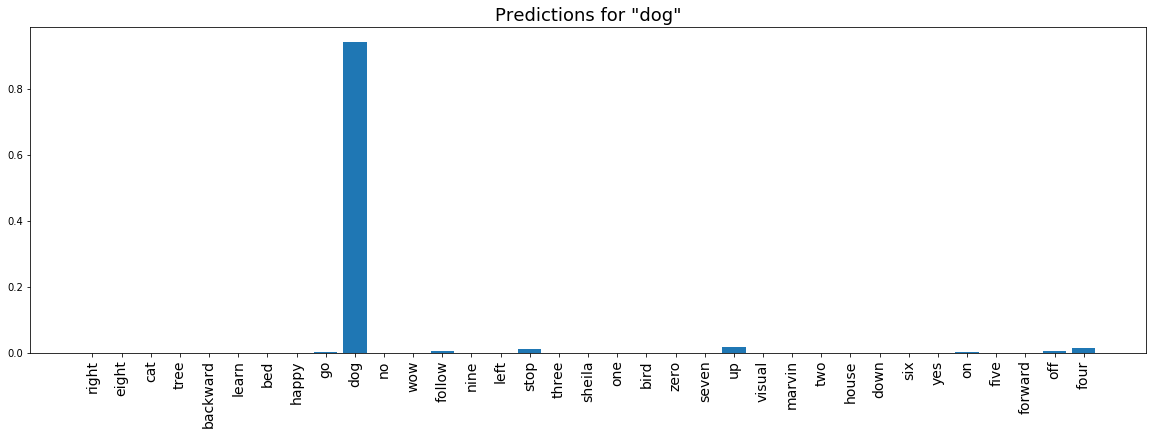

In [30]:
sample_file = data_dir / 'dog/0b09edd3_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    plt.figure(figsize=(20, 6))
    plt.bar(keywords, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{keywords[label[0]]}"', fontsize=18)
    plt.xticks(fontsize=14, rotation=90)
    plt.show();